In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from scipy import optimize, interpolate

In [2]:
# /data/df.pickleの読み込み
df = pd.read_pickle('../data/df.pickle')

df = df.dropna()

# データの分割
df_p1 = df[(df['started_at'] >= '2020-03-01') & (df['started_at'] < '2020-06-01')].dropna()
df_p2 = df[(df['started_at'] >= '2020-06-01') & (df['started_at'] < '2020-11-01')].dropna()
df_p3 = df[(df['started_at'] >= '2020-12-01') & (df['started_at'] < '2021-03-01')].dropna()
df_p4 = df[(df['started_at'] >= '2021-03-01') & (df['started_at'] < '2023-10-01')].dropna()
df_p4_1 = df[(df['started_at'] >= '2021-03-01') & (df['started_at'] < '2022-01-01')].dropna()
df_p4_2 = df[(df['started_at'] >= '2022-01-01') & (df['started_at'] < '2023-10-01')].dropna()
df_left = pd.concat([df_p1, df_p2, df_p3, df_p4_1], axis=0)
df_right = pd.concat([df_p4_2], axis=0)

In [3]:
def return_nm(df):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    # started_atで昇順にソート
    df = df.sort_values(by='started_at')
    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    node_list = []
    edge_list = []
    timestamp = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]

        # node_listにはユニークなstart_station_idを追加
        node_list.append(len(df_tmp['start_station_id'].unique()))

        # edge_listにはdf_tmpの行数を追加
        edge_list.append(len(df_tmp))

        current_timestamp = next_timestamp

    # node_listとedge_listで0の値を削除
    node_list = np.array(node_list)
    edge_list = np.array(edge_list)
    timestamp = np.array(timestamp)
    active_node_list = node_list[node_list != 0]
    edge_list = edge_list[edge_list != 0]
    timestamp = timestamp[:len(node_list)]
    
    return active_node_list, edge_list, timestamp

In [4]:
# left
node_left, edge_left, timestamp_left = return_nm(df_left)

In [5]:
# node_leftとedge_leftを組みにしてdf_leftを作成
df_left = pd.DataFrame({'node': node_left, 'edge': edge_left})
# df_leftのnodeを昇順にして並び替え
df_left = df_left.sort_values(by='node')
df_left.head()

,node,edge
60,106,190
289,136,221
288,173,312
273,215,368
290,217,494


In [6]:
def model_uniform(x, kappa):
    Np = (1 + np.sqrt((1 + 32 * x[0]) / kappa) / 2)
    return Np * (1 - (2 / (kappa * Np)) * (1 - (1 - (kappa / 2)) ** Np))

In [7]:
print("+------------------+")
print("| Estimating       |")
print("+------------------+")

params, _ = optimize.curve_fit(model_uniform, xdata=df_left["edge"], ydata=df_left["node"])

print(r"kappa:", params[0])

+------------------+
| Estimating       |
+------------------+
kappa: 0.060096722420033145


/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_13847/741625364.py:2: RuntimeWarning: invalid value encountered in sqrt
  Np = (1 + np.sqrt((1 + 32 * x[0]) / kappa) / 2)


In [15]:
kappa = params[0]
kappa = round(kappa, 2)
print("+------------------+")
Np_estimated = []
for i in range(len(df_left)):
    Np_estimated.append( (1 + np.sqrt(1 + ((32 * df_left["edge"][i]) / kappa))) / 2)

print("+       DONE       +")
print("+------------------+")


+------------------+
+       DONE       +
+------------------+


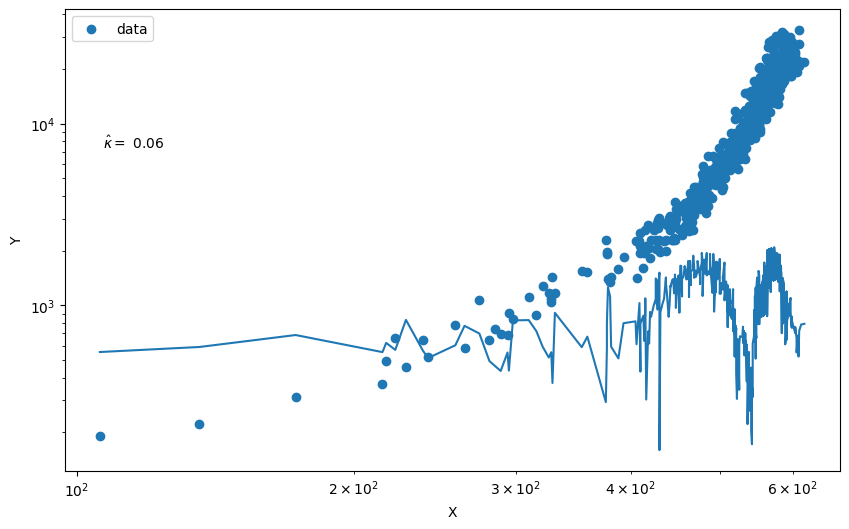

In [9]:
# 可視化
plt.figure(figsize=(10, 6))
plt.scatter(df_left["node"], df_left["edge"], label='data')
plt.plot(df_left["node"], Np_estimated)
plt.text(0.05, 0.70, r'$\hat{\kappa}=$ ' + str(kappa), transform=plt.gca().transAxes)
plt.xlabel('X')
plt.ylabel('Y')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')
plt.show()

In [10]:
# Eq8
N = []
for i in range(len(df_left)):
    N.append(Np_estimated[i] * (1 - 2/(kappa * Np_estimated[i]) * (1 - (1 - kappa/2)**Np_estimated)))
# Eq9
M = []
for i in range(len(df_left)):
    M.append((kappa * Np_estimated[i] * (Np_estimated[i] - 1)) / 8)

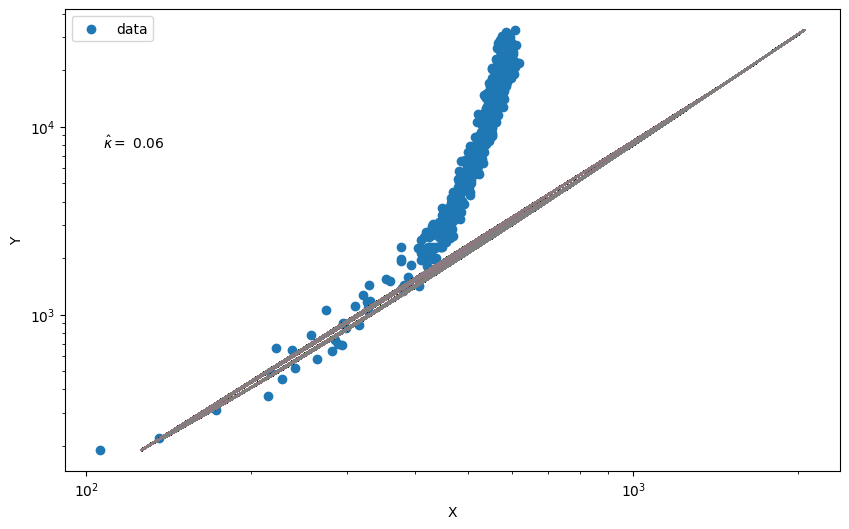

In [12]:
# 可視化
plt.figure(figsize=(10, 6))
plt.scatter(df_left["node"], df_left["edge"], label='data')
plt.plot(N, M)
plt.text(0.05, 0.70, r'$\hat{\kappa}=$ ' + str(kappa), transform=plt.gca().transAxes)
plt.xlabel('X')
plt.ylabel('Y')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')
plt.show()

In [20]:
def model_uniform_2(x, Np):
    return Np * (1 - (2 / ((8 * x[0]) / (Np - 1))) * (1 - (1 - (8 * x[0] / (2 * (Np**2 - Np))))**Np))

In [24]:
print("+------------------+")
print("| Estimating       |")
print("+------------------+")

params, _ = optimize.curve_fit(model_uniform_2, xdata=df_left["edge"], ydata=df_left["node"], p0=[800])

print(r"Np:", params[0])

+------------------+
| Estimating       |
+------------------+
Np: 553.5592221851637


In [25]:
Np = params[0]
Np = round(Np, 2)
print("+------------------+")
kappa_estimated = []
for i in range(len(df_left)):
    kappa_estimated.append( (8 * df_left["edge"][i]) / (Np**2 - Np))

print("+       DONE       +")
print("+------------------+")

+------------------+
+       DONE       +
+------------------+


In [35]:
# Eq8
N = []
for i in range(len(kappa_estimated)):
    N.append( Np * (1 - (2/(kappa_estimated[i] * Np)) * (1 - (1 - (kappa_estimated[i]/2))**Np_estimated)) )
# Eq9
M = []
for i in range(len(kappa_estimated)):
    M.append(((kappa_estimated[i] * Np**2) - (kappa_estimated[i] * Np)) / 8)

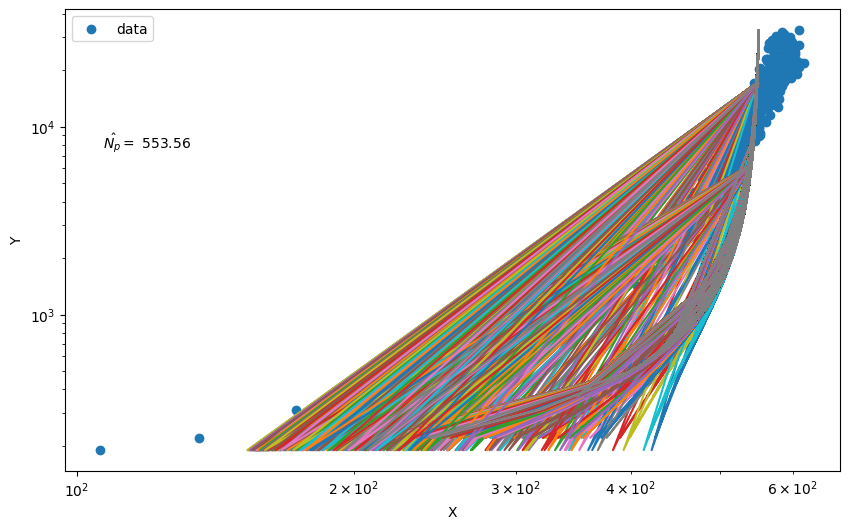

In [36]:
# 可視化
plt.figure(figsize=(10, 6))
plt.scatter(df_left["node"], df_left["edge"], label='data')
plt.plot(N, M)
plt.text(0.05, 0.70, r'$\hat{N_{p}}=$ ' + str(Np), transform=plt.gca().transAxes)
plt.xlabel('X')
plt.ylabel('Y')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')
plt.show()